Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

## 1

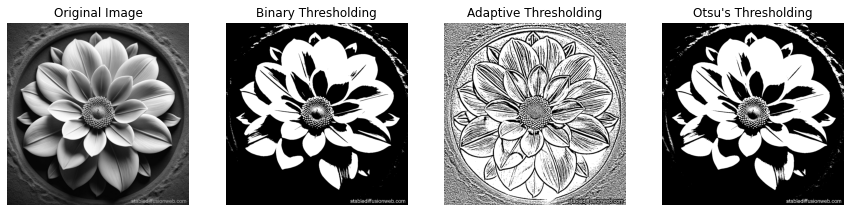

In [ ]:
image = cv2.imread('images/greyscale.jpg', cv2.IMREAD_GRAYSCALE)
_, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
display_images([image, binary_thresh, adaptive_thresh, otsu_thresh],
               ["Original Image", "Binary Thresholding", "Adaptive Thresholding", "Otsu's Thresholding"])

## 2

In [ ]:
def hough_lines(img, threshold=100):
    lines = cv2.HoughLines(img, 1, np.pi / 180, threshold)
    line_img = np.copy(image)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return line_img

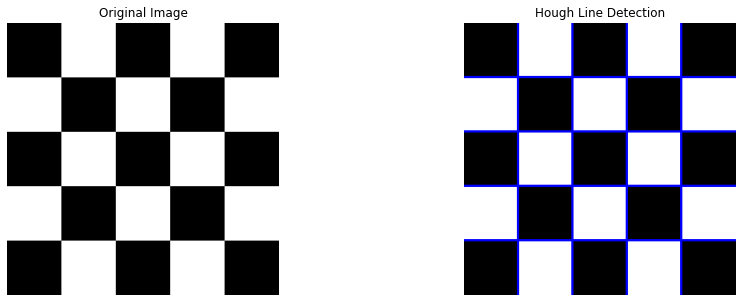

In [ ]:
image = cv2.imread('images/checkerboard.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
line_image = hough_lines(edges)
display_images([image, line_image], ["Original Image", "Hough Line Detection"])

## 3

In [ ]:
def hough_circles(img, dp=1.2, minDist=20, param1=50, param2=30, minRadius=5, maxRadius=25):
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp, minDist,
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    circle_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(circle_img, (x, y), r, (0, 255, 0), 2)
            cv2.rectangle(circle_img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    return circle_img

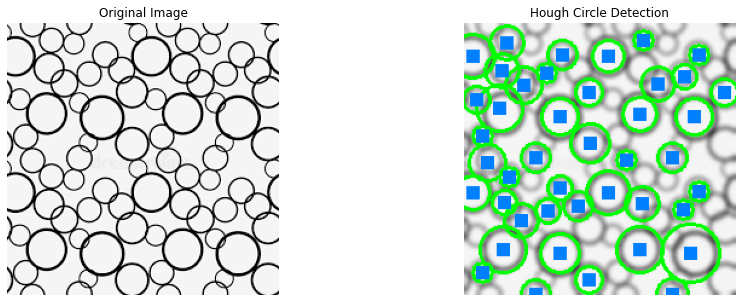

In [ ]:
image = cv2.imread('images/circles.png', cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (9, 9), 2)
circle_image = hough_circles(blurred)
display_images([image, circle_image], ["Original Image", "Hough Circle Detection"])

## 4

In [ ]:
def harris_corners(img, block_size=2, ksize=3, k=0.04):
    dst = cv2.cornerHarris(img, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    corner_img = np.copy(image)
    corner_img[dst > 0.01 * dst.max()] = [0, 0, 255]
    return corner_img

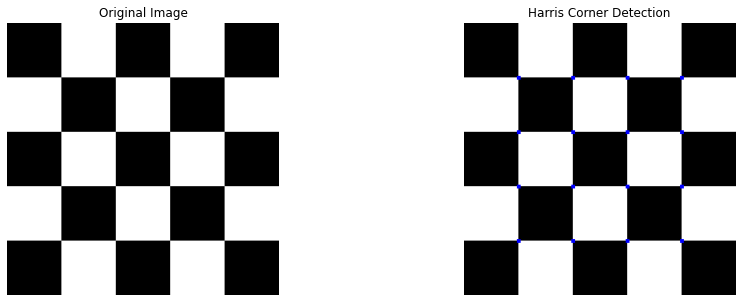

In [ ]:
image = cv2.imread('images/checkerboard.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
corner_image = harris_corners(gray)
display_images([image, corner_image], ["Original Image", "Harris Corner Detection"])